# Stability verification

The following notebook presents initialization, simulation and analysis of ion crystals in polygon traps with *Sion*. 

Contents:

1) 5-wire trap initialization  
2) Stability analysis of 2 potential wells in 5-wire trap  
3) Simulation of 2 Ca ions in separate wells 

In [1]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from mpl_toolkits.mplot3d import Axes3D
from electrode import (System, PolygonPixelElectrode, PointPixelElectrode, shaped)

import sion as sn


## Trap initialization

The following block initializes the 5-wire trap, capable of producing two almost-independent potential wells. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


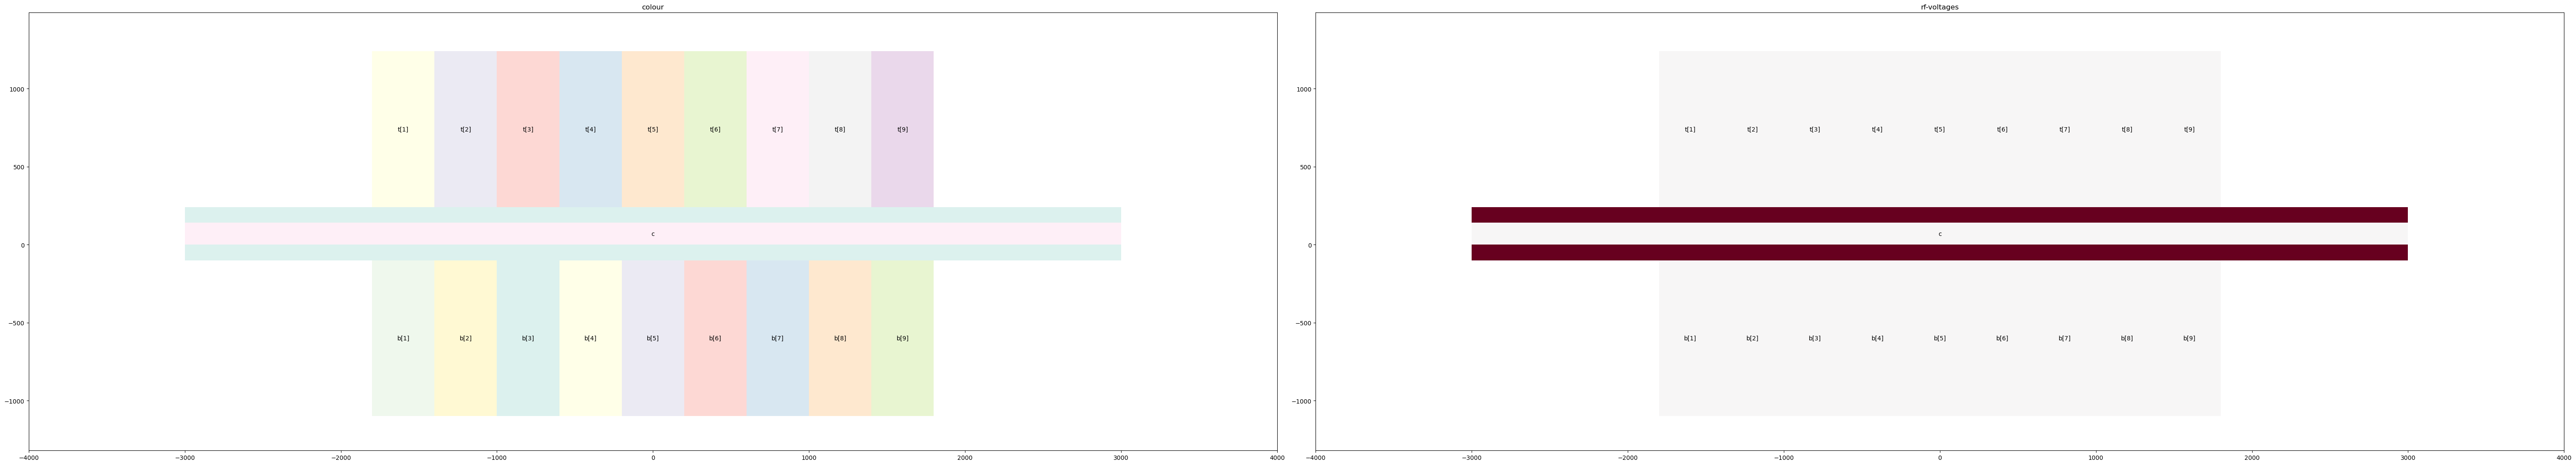

In [3]:
# Global definition of trap parameters.
L = 1e-6 # length scale
Vrf = 80. # RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*30e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)

# parameters of trap
DCtop = [[1000, 400]]  # Array of lengths and widths of Top electrodes
DCbottom = [[1000, 400]]  # Array of lengths and widths of Bottom electrodes
cwidth = 140  # Width of central dc electrode
clength = 6000 # length of central dc electrode
boardwidth = 0  # width of gaps between electrodes
rftop = 100  # width of top rf electrode, not including width of central electrode
rflength = 6000  # length of rf electrodes
rfbottom = 100  # width of bottom rf electrode

s, RF_electrodes, DC_electrodes = sn.five_wire_trap_design(Urf, DCtop ,DCbottom, cwidth, clength, boardwidth, rftop, rflength, rfbottom,patternTop = 9, patternBot = 9, need_plot = True, need_coordinates = True, save_plot = 'images/five_wire.eps')
                                                           

## Potential characterization

The following block calculates the potential minimum of Ca ions in two produced potential wells.

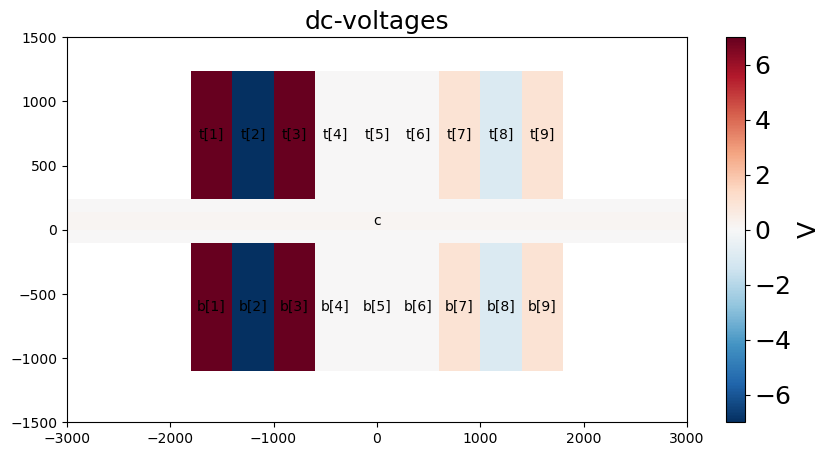

In [4]:
dc_set = 0.1*np.array([70,-70,70, 0,0,0, 10,-10,10, 70,-70,70, 0,0,0, 10,-10,10, 1.5])

u_set = np.concatenate(([0], dc_set))
rf_set = [Vrf, Vrf]
omegas = [Omega]*2
with s.with_voltages(dcs = u_set, rfs = None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    s.plot_voltages(ax, u=s.dcs)
    ax.set_title("dc-voltages", fontsize = 18)
    ax.set_xlim(-3000, 3000)
    ax.set_ylim(-1500, 1500)
    cmap = plt.cm.RdBu_r
    norm = mpl.colors.Normalize(vmin=np.min(s.dcs), vmax=np.max(s.dcs))

    cb = fig.colorbar(plt.cm.ScalarMappable(norm = norm, cmap=cmap),ax=ax,orientation = 'vertical', shrink = 1, pad = 0.05)

    cb.ax.tick_params(labelsize=18)
    cb.set_label('V', fontsize = 18)
    plt.savefig('images/trap_dc_for_stability.eps')

In [5]:
x0 = s.minimum([0,29.8,79], axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")

with s.with_voltages(dcs = u_set, rfs = None):
    print('For left potential well:')
    x1 = s.minimum(x0-np.array([1200,0,0]), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print(f'The minimum is {np.round(x1, 2)} um')
    print(f'Distance from RF-minimum in radial plane: {np.round(x1[1:]-x0[1:], 2)} um')
    curv_z, mod_dir=s.modes(x1,sorted=False)
    omega_sec=np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))

        
with s.with_voltages(dcs = u_set, rfs = None):
    print('For right potential well:')
    x2 = s.minimum(x0+np.array([1200,0,0]), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print(f'The minimum is {np.round(x2, 2)} um')
    print(f'Distance from RF-minimum in radial plane: {np.round(x2[1:]-x0[1:], 2)} um')
    curv_z, mod_dir=s.modes(x2,sorted=False)
    omega_sec=np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))

For left potential well:
The minimum is [-1200.02    70.     114.04] um
Distance from RF-minimum in radial plane: [0.   5.14] um
Secular frequencies: (nan, 1.315, 2.57) MHz
For right potential well:
The minimum is [1200.25   70.    112.96] um
Distance from RF-minimum in radial plane: [0.   4.07] um
Secular frequencies: (0.4971, 1.997, 2.134) MHz


C:\Users\User_A\AppData\Local\Temp\ipykernel_1220\3987705425.py:9: RuntimeWarning: invalid value encountered in sqrt
  omega_sec=np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6


## Stability in wells

In two potential wells, due to the DC-voltages applied, the ion stability is different - left ion is unstable, while right ion is still stable.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Left ion:


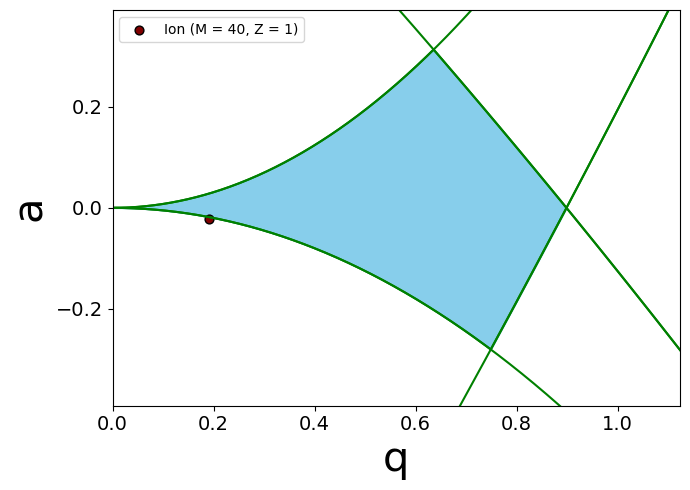

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


|Right ion:


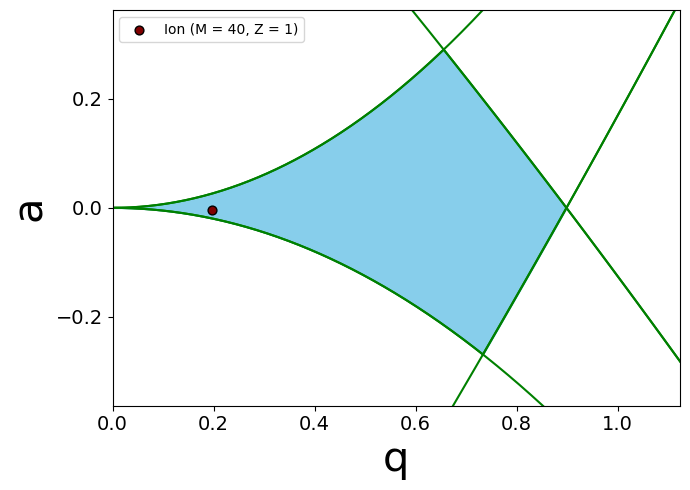

In [6]:
print('Left ion:')
with s.with_voltages(dcs = u_set, rfs = [Vrf]):
    params = sn.stability(s, mass, Omega, Z, minimum = x1, save_plot = 'images/instability.eps') 

print('|Right ion:')
with s.with_voltages(dcs = u_set, rfs = [Vrf]):
    params = sn.stability(s, mass, Omega, Z, minimum = x2, save_plot = 'images/stability.eps')

## Polygon trap simulation

The left ion is unstable, while the right is stable, so we should see, that left ion is leaving the trap on simulation.

In [8]:
# simulation of ion crystal
ion_number = 2
x01 = x1*1e-6
x02 = x2*1e-6

#insert your path to this file here
name = Path('stability.ipynb').stem

sim = pl.Simulation(name)

#ion declaration
Caions = {'mass': 40, 'charge': 1}

#placing ions
positions = [x01,x02]
sim.append(pl.placeions(Caions, positions))

#polygon trap initialization
sim.append(sn.polygon_trap(omegas, rf_set, dc_set, RF_electrodes, DC_electrodes))

#temperature and cooling
sim.append(pl.thermalvelocities(2, False))
sim.append(pl.langevinbath(0, 5e-6))

#file with simulation information
sim.append(pl.dump('logs/positions_stable.txt', variables=['x', 'y', 'z'], steps=10))
sim.append(pl.evolve(2e4))
try:
    sim.execute()
except:
    pass

Reducing timestep to 2.652582384864922e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  2 settings made for charge
2 atoms in group 1
2 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 2.65258e-10
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step CPU 
       0            0 
   100

## Ion trajectories

The following block demonstrates ion radius vector in radial direction under cooling during the simulation. We see left ion leaving the trap.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


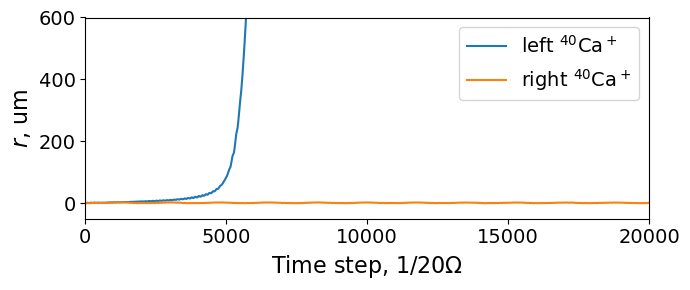

In [8]:
_, data = pl.readdump('logs/positions_stable.txt')
data *= 1e6
ion_number = 2

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

rad_vec=  []
for n in range(ion_number):
    rad_vec.append(np.sqrt(((data[:, n, 1]) - x1[1])**2+(data[:, n, 2] - x1[2])**2))
rad_vec = np.array(rad_vec)


fig = plt.figure()
fig.set_size_inches(7,3)

strr = ['left $^{40}$Ca$^+$', 'right $^{40}$Ca$^+$']
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, rad_vec[n], label = strr[n])

plt.xlabel('Time step, 1/20$\Omega$', fontsize = '16')
plt.ylabel('$r$, um', fontsize = '16')

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim(-50,600)
plt.xlim(0, 1e4)
plt.xticks([0, 5000, 10000, 15000, 20000])
plt.legend(fontsize = 14)
plt.tight_layout()
plt.savefig('images/stability_verifcation.eps', format = 'eps')

plt.show()

